# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", ***you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.**

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [360]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


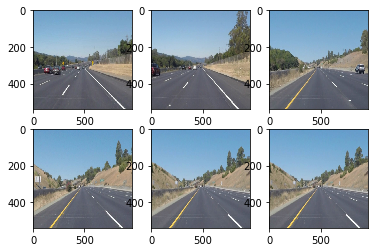

In [361]:
import os
#reading in an image
test_images_input = os.listdir("test_images/")
images=[]
for image in  os.listdir("test_images/"):
    images.append(mpimg.imread(os.path.join("test_images/",image)))
    
for image in images:
    print('This image is:', type(image), 'with dimensions:', image.shape)

# plot with various axes scales
plt.figure(1)
plt.subplot(231)
plt.imshow(images[0],aspect='auto')

plt.subplot(232)
plt.imshow(images[1],aspect='auto')

plt.subplot(233)
plt.imshow(images[2],aspect='auto')

plt.subplot(234)
plt.imshow(images[3],aspect='auto')

plt.subplot(235)
plt.imshow(images[5],aspect='auto')

plt.subplot(236)
plt.imshow(images[5],aspect='auto')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [367]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)                        
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        # i.e. will spit out count whether 3 or 4 depending on your image 
        channel_count = img.shape[2]                 
        ignore_mask_color = (255,) * channel_count   # 3 channel color mask
    else:
        ignore_mask_color = 255                      # 1 channel color mask
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)  
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)        
    return masked_image

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2): # callable from hough_lines()
    print('<>'*70)
    print("shape of This IMAGE's lines vector: ",lines.shape,'For which I have collected below stats :')
    
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4). 
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    """
    '''
    I am seperating VERTICAL, HORIZONAL, +VEslope, -VEslope line and
    added all slopes in that respective domain
    '''
    only_verticle=[]   #  m=infinity , x2-x1=0 i.e parallel to y-axis
    only_horizontal=[] #  m=0 ,y2-y1 =0 parallel to -axis
    only_positive=[]   #  m=+ve
    only_negative=[]   #  m=-ve
    postiveSlope=0
    negtiveSlope=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            sum=0
            #   +ve slope should be categorisied to left lane
            if (y2-y1)/(x2-x1) > 0 and (y2-y1)/(x2-x1)!=float("inf") :        
                only_positive.append(line)
                postiveSlope+= ((y2-y1)/(x2-x1))  
            #   -ve slope to right lane    
            elif(y2-y1)/(x2-x1) < 0 and (y2-y1)/(x2-x1)!= float("-inf") :     
                only_negative.append(line)
                negtiveSlope+= abs((y2-y1)/(x2-x1))
            # (x2-x1) is 0 i.e inf slope i.e only verticls  
            elif (y2-y1)/(x2-x1)== float("inf") or (y2-y1)/(x2-x1)== float("-inf")   :    
                only_verticle.append(line)
            # slope 0 i.e horizontal lines
            elif (y2-y1)/(x2-x1) ==0 :  
                # the horizonatal line which are < 500 should go with left lane.
                if x2<500 or x1<500:         
                    only_positive.append(line)
                # >500 should go to right lane
                else:                        
                    only_negative.append(line)
    '''
    taken AVERAGE of +ve slope, -ve slope , left_lanes , right_lanes
    '''
    posSlope_avg= postiveSlope#/len(only_positive)
    negSlope_avg= (negtiveSlope)*-1#/len(only_negative))*-1
    only_positive_avg= np.average(only_positive, axis=0)#.astype(int)  # mean of left x & y
    only_negative_avg= np.average(only_negative, axis=0)#.astype(int)  # mean of right x & y
    '''
    calculate INTERCEPTs with any single point on the average line
    ''' 
    for x1_avg,y1_avg,x2_avg,y2_avg in only_positive_avg:
        only_positive_avg_Intercept = y1_avg-(posSlope_avg*x1_avg)
    for x1_avg,y1_avg,x2_avg,y2_avg in only_negative_avg:
        only_negative_avg_Intercept = y1_avg-(negSlope_avg*x1_avg)

    '''
    calculate minmum Y among all points in left_lanes & right lanes seperatly to get the bottom most point
    and later calulated respective X using slope intercept form x = (y - b)/m
    '''
    min_left_y =  min_xy(only_positive)
    min_left_x =  int(calc_x(float(min_left_y),only_positive_avg_Intercept, posSlope_avg))  
    min_right_y= min_xy(only_negative)
    min_right_x = int(calc_x(float(min_right_y),only_negative_avg_Intercept, negSlope_avg))
    '''
    calculate maximum Y among all points in left_lanes & right lanes seperatly to get the Farthest most point
    and later calulated respective X using slope intercept form x = (y - b)/m
    '''
    max_left_y =  max_xy(only_positive)
    max_left_x = int(calc_x(float(max_left_y),only_positive_avg_Intercept, posSlope_avg)) 
    max_right_y= max_xy(only_negative)    
    max_right_x = int(calc_x(float(max_right_y),only_negative_avg_Intercept, negSlope_avg))
    '''
    Finally, Prepared top & bottom coordinates to connect & draw a line
    '''
    create_left_lane=[[min_left_x, min_left_y, max_left_x, max_left_y]]
    create_right_lane=[[min_right_x, min_right_y, max_right_x, max_right_y]]
    """
    This function draws `lines` with `color` and `thickness`. 
    Lines are drawn on the image inplace (mutates the image).If you want to make the lines semi-transparent, 
    think about combining this function with the weighted_img() function below
    """
#   left_lane_lines drawn:  ==================                                         
    for x1,y1,x2,y2 in create_left_lane:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#   right_lane_lines drawn  ==================  
    for x1,y1,x2,y2 in create_right_lane:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
    '''
    Just a printing stats to verify results simultaneously
    '''
    print("Left lane Attributes=================\n")
    print('Shape of Left lines list',len(only_positive))
    print("Average of",len(only_positive)," x's and y's in",only_positive_avg)
    print('Average posSlope',posSlope_avg,'\t cooresponding Intercept',only_positive_avg_Intercept,'\t min x',min_left_x,'& \t min y',min_left_y,'\t max x',max_left_x,'& \t max y',max_left_y)
    
    print("\nRight lane Attributes==============\n")
    print('Shape of Right lines list',len(only_negative))
    print("Average of",len(only_negative),"x's and y's in ",only_negative_avg)
    print('Average negSlope',negSlope_avg,'\t cooresponding Intercept',only_negative_avg_Intercept,'\t min x',min_right_x,'& \t min y',min_right_y,'\t max x',max_left_x,'& \t max y',max_left_y)

    print('\n\nFinal create_left_lane',create_left_lane, '\t\t create_right_lane',create_right_lane)
    print('\nshape of verticle lines collected whose slope is INFINITY, I have DISCARDED ',len(only_verticle),' many verticle line in this image')
    print('<>'*70)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # by using the dimensions of original image, creating a complete Blacked out copy of it.
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) 
    # calling the draw_lines function, which will draws lines on
    # the hough returned coordinates in fully Blacked-out Image.
    draw_lines(line_img, lines)                                             
    # this image has connected(line drawn) coordinates in complete Black-out image. 
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [368]:
abs(-125.1234)

125.1234

## Added Helper functions to support draw_lines() .

In [369]:
'''
I catched the corresponding min & max x for min & max y from the function max_xy and min_xy, but I was advised by a four mentor to 
calculate corresponding x for y's so I did that here.
Question: I still did not get clarity on Why I have to calculate x when I can retrive exact x_min for y_min as well as maxs.?????????

slope intercept form(x = (y - b)/m)
'''    
def calc_x(y,intercept, slope):
    x= ((y-intercept)//slope)
    return x
'''
This function simply calculates the min of all y's (y1 & y2) and catches their corresponding x's., But due to the issue mentioned above
I calculted x's for y's with the help of calc_x() function.
'''
def min_xy(lane_lines):
    for line in lane_lines:
        temp=960
        temp1=960
        for x1,y1,x2,y2 in line:
            if temp>=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1>=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp<temp1:
        min_y=temp
        min_x=temp_x1
    else:
        min_y=temp1
        min_x=temp1_x2
    return min_y 
'''
This function simply calculates the max of all y's (y1 & y2) and catches their corresponding x's. But due to the issue mentioned above
I calculted x's for y's with the help of calc_x() function.
'''
def max_xy(lane_lines):
    for line in lane_lines:
        temp=0
        temp1=0
        for x1,y1,x2,y2 in line:
            if temp<=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1<=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp>temp1:
        max_y=temp
        max_x=temp_x1
    else:
        max_y=temp1
        max_x=temp1_x2    
    return max_y 

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [371]:
import os,re
INPUT_PATH  = 'test_images/'
OUTPUT_PATH = 'test_images_output/'
# Automate the data fetching process.
def read_save_images(input_dir=INPUT_PATH, output_dir=OUTPUT_PATH):           
    #     read input images into a list
    test_images_input = os.listdir(input_dir)                                 
    #     output directory doesn't exist then create one
    if not os.path.isdir(output_dir):                                         
        os.makedirs(output_dir)
    
    for text_images in test_images_input:
        # read each image into program
        image = mpimg.imread( os.path.join(input_dir,text_images))   
        # send this image to your pipeline to process it
        pipeLine_output_image = laneFindingPipeLine(image)                    
        modify_name = re.sub(r'\.jpg$', '', text_images)
        # put the final image into the directory
        mpimg.imsave( os.path.join(output_dir,modify_name+'_output.jpg'),pipeLine_output_image) 
    return  

In [372]:
'''
simply calling the pipeline here
'''
read_save_images()

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (108, 1, 4) For which I have collected below stats :
left min x 467 for min y 525
left min x 416 for min y 388
left min x 469 for min y 538
left min x 415 for min y 391
Left lane Attributes=================

Shape of Left lines list 40
Average of 40  x's and y's in [[ 435.275  328.45   476.05   344.1  ]]
Average posSlope 6.1287884704 	 cooresponding Intercept -2339.25840146 	 min x 467 & 	 min y 525 	 max x 469 & 	 max y 538

Right lane Attributes==============

Shape of Right lines list 67
Average of 67 x's and y's in  [[ 422.2238806   311.82089552  441.02985075  307.1641791 ]]
Average negSlope -12.6400406225 	 cooresponding Intercept 5648.74789804 	 min x 416 & 	 min y 388 	 max x 469 & 	 max y 538


Final create_left_lane [[467, 525, 469, 538]] 		 create_right_lane [[416, 388, 415, 391]]

shape of verticle l

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [373]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def laneFindingPipeLine(img):
#     plt.figure(2)
#     print('Original_image shape',img.shape )
#     plt.subplot(331)
#     plt.imshow(img,aspect='auto')
    '''
     to apply canny algorithm, convert color image to gray i,e a single channel image
     gray image helps us to clearly identify, DARK/ BRIGHT/ GRAY(in between) pixels in the image. 
     Also, rapid changing in the brightess, we will be able to find edges/dots
    '''
    gray_image = grayscale(img)
#     print('gray_image shape',gray_image.shape )
#     plt.subplot(332)
#     plt.imshow(gray_image,aspect='auto')
    
    '''
    filter-out noise and spurious gradients by averaging  with gaussian filter, keeping Kernel_size = 5, **always select a odd size number.
    '''
    kernel_size=5
    blur_gray = gaussian_blur(gray_image, kernel_size)
#     print('blur_gray shape',blur_gray.shape )
#     plt.subplot(333)
#     plt.imshow(blur_gray,aspect='auto')
    '''
    now, we can apply canny algorithm, that
    apply its gaussian filter--> finds the gradient strength & direction(you get thick edges)-->apply non-max. suppression(get thin/candidate edges)-->Hysteresis with the help of thresholds specifies in the arguments
    '''
    low_threshold  = 70
    high_threshold = 140
    canny_edges = canny(blur_gray, low_threshold, high_threshold)
#     print('canny_edges shape',canny_edges.shape )
#     plt.subplot(334)
#     plt.imshow(canny_edges,aspect='auto')
    '''
    Work is not done YET..!!
    We just have dotted-lane-lines detected.
    So, we connect them..? How we know which dot to connect with which other dot, & how many dots to connect? ...TRICKY SITUATION...!!!
    Awesome Manipulation by hough, We have dots in our image space, which equivalent to a line for each dot in Hough space. And, collinear points in image space
    is equivalent to respective lines passing through common intersection point/pixel in Hough space. Also, in Hough space we have grids cells, which helps to 
    catch all the edges/dots in images space which are not collinear but very much near to collinear points by adjusting THRESHOLD parameter in below function.
    The more count we get of lines passing through a grid pixel in hough space, the more we get collinear/near-collinear edges/dots in out image space.
    This way we will be able to clear identify the sequence of coordinates of all near-collinear points in the canny_edge_detected_masked_image ....AMAZING..!!
    
    Now, you have the coordinates, Connect them with a line, by calling custom draw_lines()
    '''
    rho = 1
    theta = np.pi/180
    threshold = 12
    min_line_len = 10
    max_line_gap = 2
    line_img = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap) # --> will call draw lines & you get a Blacked-out image with connected Hough returned coordinates.
#     print('line_img shape',line_img.shape )
#     plt.subplot(335)
#     plt.imshow(line_img,aspect='auto')
    '''
    Now, you have a edge-detected image : which has edges all over the image based on you detection criterion. This doesn't solve our purpose. 
    We need to narrow-down our area of visibility to not to let our algorithm confuse.
    Create a region of interest, a polygon around the specific lane line.
    This function takes the coordinates of the polygon and draws a polygon in the image,
    then fill with a RED color <-- this becomes your mask.(a specific area to look on.)
    then it performs bitwise AND with canny_edge_detected_image(which is full of edges everywhere) & mask_image(just a plane RED POLYGON SHAPE in the image)--> gives a canny_edge_detected_masked_image
    So, now you have clear RED-HIGHLIGHTNED canny- edges....BEAUTIFULL..!!! :)
    
    Note: Create a mask is independent of any operatio, Moreover, you want to create Mask on the line_image that's why you have to 
          do a bit-wise AND to get only the masked-line Image. Do not repeat it again...!!!!
    '''
    vertices = np.array([[(0,539),(425, 340), (510, 320), (959,539)]], dtype=np.int32)
    masked_image = region_of_interest(img, vertices)
#     print('masked_image shape',masked_image.shape )
#     plt.subplot(336)
#     plt.imshow(masked_image,aspect='auto')
    '''
    have to mask the line_image so that we can get the specific area in the image to look on
    '''
    masked_line_img = cv2.bitwise_and(masked_image, line_img)
#     print('masked_line_img shape',masked_line_img.shape )
#     plt.subplot(337)
#     plt.imshow(masked_line_img,aspect='auto')
    '''
    now we have 1. a image with hough generated connected coordinates
                2. a image with masked-region(polygon) with canny detected edges. 
    this function will give weights to each pixel & glue them together. 
    Remember, before gluing, the dimension shoudld be same, else it pops out errors.
    img==1 & initial_img==2(original image)
    '''
    output = weighted_img(masked_line_img, img, α=0.8, β=1., λ=0.)
#     print('output shape',output.shape )
#     plt.subplot(338)
#     plt.imshow(output,aspect='auto')
    return output


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [374]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output shape (540, 960, 4)


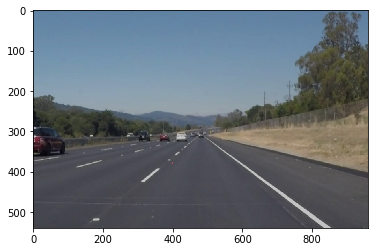

In [375]:
if not os.path.isdir('test_videos_output/'):         #     output directory doesn't exist then create one
        os.makedirs('test_videos_output/')
    
image = mpimg.imread(os.path.join('test_images_output/solidWhiteRight_output.jpg'))
print('output shape',image.shape )
plt.imshow(image,aspect='auto') 
plt.show()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)  
    result = laneFindingPipeLine(image)   
    return result                    

Let's try the one with the solid white lane on the right first ...

In [376]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (205, 1, 4) For which I have collected below stats :
left min x 646 for min y 320
left min x 544 for min y 445
left min x 646 for min y 327
left min x 544 for min y 454
Left lane Attributes=================

Shape of Left lines list 92
Average of 92  x's and y's in [[ 646.56521739  288.2173913   673.22826087  299.02173913]]
Average posSlope 99.1883449943 	 cooresponding Intercept -63843.5164526 	 min x 646 & 	 min y 320 	 max x 646 & 	 max y 327

Right lane Attributes==============

Shape of Right lines list 110
Average of 110 x's and y's in  [[ 551.60909091  218.          571.95454545  212.12727273]]
Average negSlope -32.7763050625 	 cooresponding Intercept 18297.7078389 	 min x 544 & 	 min y 445 	 max x 646 & 	 max y 327


Final create_left_lane [[646, 320, 646, 327]] 		 create_right_lane [[544, 445, 544, 454

  2%|▏         | 5/222 [00:00<00:04, 49.56it/s]

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (205, 1, 4) For which I have collected below stats :
left min x 646 for min y 320
left min x 544 for min y 445
left min x 646 for min y 327
left min x 544 for min y 454
Left lane Attributes=================

Shape of Left lines list 92
Average of 92  x's and y's in [[ 646.56521739  288.2173913   673.22826087  299.02173913]]
Average posSlope 99.1883449943 	 cooresponding Intercept -63843.5164526 	 min x 646 & 	 min y 320 	 max x 646 & 	 max y 327

Right lane Attributes==============

Shape of Right lines list 110
Average of 110 x's and y's in  [[ 551.60909091  218.          571.95454545  212.12727273]]
Average negSlope -32.7763050625 	 cooresponding Intercept 18297.7078389 	 min x 544 & 	 min y 445 	 max x 646 & 	 max y 327


Final create_left_lane [[646, 320, 646, 327]] 		 create_right_lane [[544, 445, 544, 454

  4%|▎         | 8/222 [00:00<00:05, 39.05it/s]

334
Left lane Attributes=================

Shape of Left lines list 63
Average of 63  x's and y's in [[ 550.53968254  331.          583.19047619  343.84126984]]
Average posSlope 29.1117168894 	 cooresponding Intercept -15696.1553745 	 min x 550 & 	 min y 344 	 max x 551 & 	 max y 352

Right lane Attributes==============

Shape of Right lines list 58
Average of 58 x's and y's in  [[ 428.62068966  307.9137931   444.44827586  302.22413793]]
Average negSlope -51.217305291 	 cooresponding Intercept 22260.7105092 	 min x 428 & 	 min y 334 	 max x 551 & 	 max y 352


Final create_left_lane [[550, 344, 551, 352]] 		 create_right_lane [[428, 334, 428, 334]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

  5%|▌         | 12/222 [00:00<00:05, 38.89it/s]


shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (101, 1, 4) For which I have collected below stats :
left min x 543 for min y 439
left min x 414 for min y 434
left min x 544 for min y 451
left min x 414 for min y 441
Left lane Attributes=================

Shape of Left lines list 37
Average of 37  x's and y's in [[ 540.43243243  334.13513514  581.89189189  353.64864865]]
Average posSlope 32.1619640444 	 cooresponding Intercept -17047.2333252 	 min x 543 & 	 min y 439 	 max x 544 & 	 max y 451

Right lane Attributes==============

Shape of Right lines list 60
Average of 60 x's and y's in  [[ 416.91666667  324

  7%|▋         | 15/222 [00:00<00:05, 35.69it/s]


Average negSlope -43.7147037264 	 cooresponding Intercept 18549.9052286 	 min x 414 & 	 min y 434 	 max x 544 & 	 max y 451


Final create_left_lane [[543, 439, 544, 451]] 		 create_right_lane [[414, 434, 414, 441]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  4  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (92, 1, 4) For which I have collected below stats :
left min x 456 for min y 395
left min x 411 for min y 512
left min x 457 for min y 398
left min x 411 for min y 519
Left lane Attributes=================

Shape of Left lines list 34
Average of 34  x's and y's in [[ 447.38235294  318.35294118  496.55882353  340.20588235]]
Average posSlope 8.215356

  9%|▊         | 19/222 [00:00<00:05, 36.54it/s]

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (92, 1, 4) For which I have collected below stats :
left min x 430 for min y 529
left min x 348 for min y 509
left min x 431 for min y 539
left min x 348 for min y 517
Left lane Attributes=================

Shape of Left lines list 36
Average of 36  x's and y's in [[ 420.75        311.16666667  463.47222222  329.22222222]]
Average posSlope 22.0420211261 	 cooresponding Intercept -8963.01372214 	 min x 430 & 	 min y 529 	 max x 431 & 	 max y 539

Right lane Attributes==============

Shape of Right lines list 50
Average of 50 x's and y's in  [[ 358.2   338.42  376.42  331.38]]
Average negSlope -18.5053328105 	 cooresponding Intercept 6967.03021271 	 min x 348 & 	 min y 509 	 max x 431 & 	 max y 539


Final create_left_lane [[430, 529, 431, 539]] 		 create_right_lane [[348, 509, 348, 517]]

shape of verticle lines

 10%|▉         | 22/222 [00:00<00:05, 33.57it/s]


Shape of Right lines list 56
Average of 56 x's and y's in  [[ 381.33928571  312.16071429  399.05357143  307.19642857]]
Average negSlope -14.6074571389 	 cooresponding Intercept 5882.55798572 	 min x 374 & 	 min y 407 	 max x 454 & 	 max y 370


Final create_left_lane [[454, 369, 454, 370]] 		 create_right_lane [[374, 407, 374, 414]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (96, 1, 4) For which I have collected below stats :
left min x 430 for min y 478
left min x 405 for min y 232
left min x 430 for min y 489
left min x 405 for min y 233
Left lane Attributes=================

Shape of Left lines list

 12%|█▏        | 26/222 [00:00<00:05, 34.91it/s]

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (102, 1, 4) For which I have collected below stats :
left min x 465 for min y 395
left min x 399 for min y 413
left min x 465 for min y 397
left min x 399 for min y 421
Left lane Attributes=================

Shape of Left lines list 48
Average of 48  x's and y's in [[ 462.125       313.20833333  502.72916667  331.95833333]]
Average posSlope 27.8666839485 	 cooresponding Intercept -12564.6829864 	 min x 465 & 	 min y 395 	 max x 465 & 	 max y 397

Right lane Attributes==============

Shape of Right lines list 53
Average of 53 x's and y's in  [[ 405.22641509  299.88679245  426.73584906  292.60377358]]
Average negSlope -21.0525557058 	 cooresponding Intercept 8830.9384697 	 min x 399 & 	 min y 413 	 max x 465 & 	 max y 397


Final create_left_lane [[465, 395, 465, 397]] 		 create_right_lane [[399, 413, 399, 421]]


 14%|█▎        | 30/222 [00:00<00:05, 34.92it/s]

For which I have collected below stats :
left min x 434 for min y 498
left min x 406 for min y 240
left min x 434 for min y 508
left min x 406 for min y 242
Left lane Attributes=================

Shape of Left lines list 49
Average of 49  x's and y's in [[ 426.57142857  322.06122449  460.40816327  336.        ]]
Average posSlope 22.4653264921 	 cooresponding Intercept -9261.00519055 	 min x 434 & 	 min y 498 	 max x 434 & 	 max y 508

Right lane Attributes==============

Shape of Right lines list 48
Average of 48 x's and y's in  [[ 403.3125      307.25        420.375       302.83333333]]
Average negSlope -22.4550394135 	 cooresponding Intercept 9363.64808346 	 min x 406 & 	 min y 240 	 max x 434 & 	 max y 508


Final create_left_lane [[434, 498, 434, 508]] 		 create_right_lane [[406, 240, 406, 242]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  6  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><

 15%|█▌        | 34/222 [00:00<00:05, 34.59it/s]

for min y 420
Left lane Attributes=================

Shape of Left lines list 35
Average of 35  x's and y's in [[ 424.62857143  319.37142857  478.54285714  343.82857143]]
Average posSlope 29.3782319763 	 cooresponding Intercept -12155.4652466 	 min x 423 & 	 min y 291 	 max x 423 & 	 max y 292

Right lane Attributes==============

Shape of Right lines list 53
Average of 53 x's and y's in  [[ 408.37735849  313.56603774  426.64150943  307.9245283 ]]
Average negSlope -18.1653912201 	 cooresponding Intercept 7731.90052016 	 min x 403 & 	 min y 406 	 max x 423 & 	 max y 292


Final create_left_lane [[423, 291, 423, 292]] 		 create_right_lane [[403, 406, 402, 420]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><

 17%|█▋        | 38/222 [00:01<00:05, 34.98it/s]


left min x 374 for min y 532
Left lane Attributes=================

Shape of Left lines list 47
Average of 47  x's and y's in [[ 389.5106383   317.55319149  435.21276596  337.53191489]]
Average posSlope 31.7965528812 	 cooresponding Intercept -12067.5424169 	 min x 395 & 	 min y 496 	 max x 396 & 	 max y 538

Right lane Attributes==============

Shape of Right lines list 51
Average of 51 x's and y's in  [[ 381.50980392  334.58823529  405.90196078  324.01960784]]
Average negSlope -28.2711365052 	 cooresponding Intercept 11120.30398 	 min x 374 & 	 min y 519 	 max x 396 & 	 max y 538


Final create_left_lane [[395, 496, 396, 538]] 		 create_right_lane [[374, 519, 374, 532]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  3  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><

 19%|█▉        | 42/222 [00:01<00:05, 34.34it/s]

 463 & 	 max y 337

Right lane Attributes==============

Shape of Right lines list 65
Average of 65 x's and y's in  [[ 410.8         311.46153846  426.69230769  307.21538462]]
Average negSlope -28.0635924301 	 cooresponding Intercept 11839.9853087 	 min x 416 & 	 min y 148 	 max x 463 & 	 max y 337


Final create_left_lane [[463, 324, 463, 337]] 		 create_right_lane [[416, 148, 416, 160]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (107, 1, 4) For which I have collected below stats :
left min x 415 for min y 529
left min x 420 for min y 364
left min x 415 for min y 538
left min x 419 for min y 368
Left l

 21%|██        | 46/222 [00:01<00:05, 32.33it/s]

492 for min y 467
left min x 388 for min y 514
left min x 492 for min y 486
left min x 388 for min y 515
Left lane Attributes=================

Shape of Left lines list 55
Average of 55  x's and y's in [[ 490.52727273  326.76363636  522.72727273  342.25454545]]
Average posSlope 79.4187630654 	 cooresponding Intercept -38630.3056135 	 min x 492 & 	 min y 467 	 max x 492 & 	 max y 486

Right lane Attributes==============

Shape of Right lines list 59
Average of 59 x's and y's in  [[ 401.01694915  311.98305085  420.27118644  306.76271186]]
Average negSlope -15.820755467 	 cooresponding Intercept 6656.37414151 	 min x 388 & 	 min y 514 	 max x 492 & 	 max y 486


Final create_left_lane [[492, 467, 492, 486]] 		 create_right_lane [[388, 514, 388, 515]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  3  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

 23%|██▎       | 50/222 [00:01<00:05, 31.88it/s]

 -30766.4348116 	 min x 431 & 	 min y 335 	 max x 431 & 	 max y 346

Right lane Attributes==============

Shape of Right lines list 74
Average of 74 x's and y's in  [[ 385.82432432  318.66216216  405.75675676  311.66216216]]
Average negSlope -25.1734053997 	 cooresponding Intercept 10031.1742914 	 min x 380 & 	 min y 452 	 max x 431 & 	 max y 346


Final create_left_lane [[431, 335, 431, 346]] 		 create_right_lane [[380, 452, 379, 466]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (124, 1, 4) For which I have collected below stats :
left min x 417 for min y 500
left min x 362 for min y 482
left min x 417 

 24%|██▍       | 54/222 [00:01<00:05, 31.49it/s]

	 min x 451 & 	 min y 368 	 max x 456 & 	 max y 506


Final create_left_lane [[456, 485, 456, 506]] 		 create_right_lane [[451, 368, 450, 379]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  3  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (102, 1, 4) For which I have collected below stats :
left min x 385 for min y 289
left min x 400 for min y 274
left min x 385 for min y 289
left min x 399 for min y 287
Left lane Attributes=================

Shape of Left lines list 41
Average of 41  x's and y's in [[ 388.36585366  307.2195122   432.56097561  326.82926829]]
Average posSlope 7.28835596021 	 cooresponding Intercept -2523.32907206 	 min x 385 & 	 min y 289

 26%|██▌       | 58/222 [00:01<00:05, 31.32it/s]

421
Left lane Attributes=================

Shape of Left lines list 50
Average of 50  x's and y's in [[ 393.88  310.3   429.18  325.52]]
Average posSlope 50.3072286335 	 cooresponding Intercept -19504.7112142 	 min x 398 & 	 min y 521 	 max x 398 & 	 max y 537

Right lane Attributes==============

Shape of Right lines list 63
Average of 63 x's and y's in  [[ 362.52380952  312.76190476  380.28571429  307.19047619]]
Average negSlope -19.8440241484 	 cooresponding Intercept 7506.69313531 	 min x 357 & 	 min y 409 	 max x 398 & 	 max y 537


Final create_left_lane [[398, 521, 398, 537]] 		 create_right_lane [[357, 409, 357, 421]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  7  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><

 28%|██▊       | 62/222 [00:01<00:05, 31.64it/s]

Shape of Right lines list 65
Average of 65 x's and y's in  [[ 404.8         320.43076923  425.47692308  313.32307692]]
Average negSlope -18.274948491 	 cooresponding Intercept 7718.12991839 	 min x 400 & 	 min y 399 	 max x 424 & 	 max y 524


Final create_left_lane [[423, 516, 424, 524]] 		 create_right_lane [[400, 399, 400, 402]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  9  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (130, 1, 4) For which I have collected below stats :
left min x 482 for min y 437
left min x 375 for min y 496
left min x 482 for min y 444
left min x 375 for min y 503
Left lane Attributes=================

Shape of Left lines list 

 30%|██▉       | 66/222 [00:01<00:04, 32.89it/s]

 458 for min y 393
left min x 393 for min y 390
Left lane Attributes=================

Shape of Left lines list 43
Average of 43  x's and y's in [[ 455.53488372  323.1627907   501.93023256  344.88372093]]
Average posSlope 23.064458822 	 cooresponding Intercept -10183.5027769 	 min x 457 & 	 min y 378 	 max x 458 & 	 max y 393

Right lane Attributes==============

Shape of Right lines list 60
Average of 60 x's and y's in  [[ 399.58333333  308.65        415.65        304.63333333]]
Average negSlope -13.8791504555 	 cooresponding Intercept 5854.52720285 	 min x 394 & 	 min y 376 	 max x 458 & 	 max y 393


Final create_left_lane [[457, 378, 458, 393]] 		 create_right_lane [[394, 376, 393, 390]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><>

 32%|███▏      | 70/222 [00:02<00:04, 32.92it/s]

for min y 440
left min x 381 for min y 423
left min x 450 for min y 456
left min x 381 for min y 432
Left lane Attributes=================

Shape of Left lines list 36
Average of 36  x's and y's in [[ 438.86111111  331.75        484.36111111  354.08333333]]
Average posSlope 10.9125501602 	 cooresponding Intercept -4457.34388837 	 min x 448 & 	 min y 440 	 max x 450 & 	 max y 456

Right lane Attributes==============

Shape of Right lines list 70
Average of 70 x's and y's in  [[ 385.64285714  317.52857143  403.27142857  312.8       ]]
Average negSlope -27.4418442917 	 cooresponding Intercept 10900.2798094 	 min x 381 & 	 min y 423 	 max x 450 & 	 max y 456


Final create_left_lane [[448, 440, 450, 456]] 		 create_right_lane [[381, 423, 381, 432]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  10  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

 33%|███▎      | 74/222 [00:02<00:04, 32.93it/s]

7106.75516225 	 min x 376 & 	 min y 398 	 max x 448 & 	 max y 463


Final create_left_lane [[448, 447, 448, 463]] 		 create_right_lane [[376, 398, 376, 401]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  6  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (114, 1, 4) For which I have collected below stats :
left min x 453 for min y 445
left min x 391 for min y 527
left min x 453 for min y 463
left min x 390 for min y 538
Left lane Attributes=================

Shape of Left lines list 45
Average of 45  x's and y's in [[ 451.33333333  330.64444444  486.2         345.95555556]]
Average posSlope 58.5399289636 	 cooresponding Intercept -26090.3768278 	 min x 453

 35%|███▌      | 78/222 [00:02<00:04, 32.11it/s]

 [[428, 482, 427, 526]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  7  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (107, 1, 4) For which I have collected below stats :
left min x 501 for min y 421
left min x 483 for min y 253
left min x 502 for min y 466
left min x 483 for min y 255
Left lane Attributes=================

Shape of Left lines list 53
Average of 53  x's and y's in [[ 500.0754717   320.75471698  533.69811321  336.41509434]]
Average posSlope 55.6504419716 	 cooresponding Intercept -27508.6663022 	 min x 501 & 	 min y 421 	 max x 502 & 	 max y 466

Right lane Attributes==============

Shape of Right lines list 48
Average of 48 x's and y's 

 37%|███▋      | 82/222 [00:02<00:04, 31.53it/s]

Average of 61 x's and y's in  [[ 408.29508197  307.67213115  425.29508197  302.91803279]]
Average negSlope -24.9969872929 	 cooresponding Intercept 10513.8191069 	 min x 412 & 	 min y 211 	 max x 455 & 	 max y 376


Final create_left_lane [[455, 373, 455, 376]] 		 create_right_lane [[412, 211, 412, 215]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (116, 1, 4) For which I have collected below stats :
left min x 423 for min y 249
left min x 400 for min y 390
left min x 425 for min y 276
left min x 399 for min y 400
Left lane Attributes=================

Shape of Left lines list 45
Average of 45  x's and y'

 39%|███▊      | 86/222 [00:02<00:04, 31.76it/s]

73
Average of 73 x's and y's in  [[ 391.8630137   330.63013699  411.83561644  324.60273973]]
Average negSlope -19.572984896 	 cooresponding Intercept 8000.55898543 	 min x 384 & 	 min y 478 	 max x 511 & 	 max y 447


Final create_left_lane [[510, 426, 511, 447]] 		 create_right_lane [[384, 478, 383, 489]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (131, 1, 4) For which I have collected below stats :
left min x 545 for min y 374
left min x 394 for min y 525
left min x 545 for min y 403
left min x 393 for min y 532
Left lane Attributes=================

Shape of Left lines list 44
Average of 44  x's and 

 41%|████      | 90/222 [00:02<00:04, 31.66it/s]

		 create_right_lane [[414, 501, 413, 530]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (120, 1, 4) For which I have collected below stats :
left min x 471 for min y 427
left min x 427 for min y 364
left min x 471 for min y 437
left min x 427 for min y 367
Left lane Attributes=================

Shape of Left lines list 48
Average of 48  x's and y's in [[ 469.1875      320.125       504.39583333  337.25      ]]
Average posSlope 50.7138264862 	 cooresponding Intercept -23474.1684645 	 min x 471 & 	 min y 427 	 max x 471 & 	 max y 437

Right lane Attributes==============

Shape of Right lines list 65
Averag

 42%|████▏     | 94/222 [00:02<00:04, 29.69it/s]

left min x 514 for min y 430
left min x 444 for min y 392
left min x 514 for min y 434
left min x 443 for min y 410
Left lane Attributes=================

Shape of Left lines list 51
Average of 51  x's and y's in [[ 513.25490196  331.84313725  551.8627451   350.35294118]]
Average posSlope 76.0817087375 	 cooresponding Intercept -38717.4668218 	 min x 514 & 	 min y 430 	 max x 514 & 	 max y 434

Right lane Attributes==============

Shape of Right lines list 70
Average of 70 x's and y's in  [[ 446.          305.92857143  462.05714286  300.88571429]]
Average negSlope -49.8054109762 	 cooresponding Intercept 22519.1418668 	 min x 444 & 	 min y 392 	 max x 514 & 	 max y 434


Final create_left_lane [[514, 430, 514, 434]] 		 create_right_lane [[444, 392, 443, 410]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  6  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

 44%|████▎     | 97/222 [00:02<00:04, 29.06it/s]


Right lane Attributes==============

Shape of Right lines list 70
Average of 70 x's and y's in  [[ 379.91428571  323.94285714  401.84285714  316.3       ]]
Average negSlope -22.7689362125 	 cooresponding Intercept 8974.18699477 	 min x 375 & 	 min y 425 	 max x 475 & 	 max y 354


Final create_left_lane [[475, 343, 475, 354]] 		 create_right_lane [[375, 425, 372, 482]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  4  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (118, 1, 4) For which I have collected below stats :
left min x 442 for min y 437
left min x 391 for min y 446
left min x 442 for min y 447
left min x 390 for min y 461
Left lane Attributes=====

 45%|████▌     | 101/222 [00:03<00:03, 30.81it/s]

Average posSlope 24.0734036165 	 cooresponding Intercept -11074.8307401 	 min x 481 & 	 min y 512 	 max x 481 & 	 max y 521

Right lane Attributes==============

Shape of Right lines list 60
Average of 60 x's and y's in  [[ 370.55        343.21666667  389.78333333  337.05      ]]
Average negSlope -15.7386850581 	 cooresponding Intercept 6175.18641496 	 min x 358 & 	 min y 527 	 max x 481 & 	 max y 521


Final create_left_lane [[481, 512, 481, 521]] 		 create_right_lane [[358, 527, 358, 538]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  8  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (114, 1, 4) For which I have collected below stats :
left min x 426 fo

 47%|████▋     | 105/222 [00:03<00:03, 31.73it/s]

394 	 max x 473 & 	 max y 525


Final create_left_lane [[473, 514, 473, 525]] 		 create_right_lane [[484, 394, 484, 408]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  6  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (97, 1, 4) For which I have collected below stats :
left min x 420 for min y 412
left min x 385 for min y 400
left min x 421 for min y 451
left min x 385 for min y 408
Left lane Attributes=================

Shape of Left lines list 38
Average of 38  x's and y's in [[ 418.76315789  308.97368421  466.5         332.81578947]]
Average posSlope 50.5509531888 	 cooresponding Intercept -20859.9031077 	 min x 420 & 	 min y 412 	 max x 421 & 	 max y 

 49%|████▉     | 109/222 [00:03<00:03, 32.58it/s]


left min x 358 for min y 447
Left lane Attributes=================

Shape of Left lines list 47
Average of 47  x's and y's in [[ 409.14893617  309.14893617  451.87234043  329.82978723]]
Average posSlope 31.4030046683 	 cooresponding Intercept -12539.3570164 	 min x 406 & 	 min y 225 	 max x 406 & 	 max y 228

Right lane Attributes==============

Shape of Right lines list 61
Average of 61 x's and y's in  [[ 359.37704918  330.44262295  381.16393443  322.37704918]]
Average negSlope -90.9887732892 	 cooresponding Intercept 33029.7194762 	 min x 358 & 	 min y 437 	 max x 406 & 	 max y 228


Final create_left_lane [[406, 225, 406, 228]] 		 create_right_lane [[358, 437, 358, 447]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  9  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><

 51%|█████     | 113/222 [00:03<00:03, 33.06it/s]

 many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (134, 1, 4) For which I have collected below stats :
left min x 397 for min y 459
left min x 384 for min y 241
left min x 397 for min y 474
left min x 384 for min y 251
Left lane Attributes=================

Shape of Left lines list 59
Average of 59  x's and y's in [[ 394.6779661   307.98305085  428.83050847  324.47457627]]
Average posSlope 61.7969467666 	 cooresponding Intercept -24081.9102103 	 min x 397 & 	 min y 459 	 max x 397 & 	 max y 474

Right lane Attributes==============

Shape of Right lines list 66
Average of 66 x's and y's in  [[ 382.36363636  323.93939394  399.92424242  318.92424242]]
Average negSlope -42.1407369422 	 coores

 53%|█████▎    | 117/222 [00:03<00:03, 33.59it/s]


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (131, 1, 4) For which I have collected below stats :
left min x 448 for min y 478
left min x 382 for min y 394
left min x 448 for min y 486
left min x 382 for min y 409
Left lane Attributes=================

Shape of Left lines list 63
Average of 63  x's and y's in [[ 446.73015873  329.44444444  478.46031746  344.46031746]]
Average posSlope 78.6800953572 	 cooresponding Intercept -34819.3270434 	 min x 448 & 	 min y 478 	 max x 448 & 	 max y 486

Right lane Attributes==============

Shape of Right lines list 59
Average of 59 x's and y's in  [[ 384.83050847  320.44067797  401.55932203  315.88135593]]
Average negSlope -31.4903798432 	 cooresponding Intercept 12438.8995651 	

 55%|█████▍    | 121/222 [00:03<00:03, 33.63it/s]

375 for min y 424
left min x 377 for min y 394
left min x 376 for min y 463
left min x 377 for min y 396
Left lane Attributes=================

Shape of Left lines list 55
Average of 55  x's and y's in [[ 370.10909091  321.92727273  406.58181818  337.74545455]]
Average posSlope 20.8427806196 	 cooresponding Intercept -7392.17531441 	 min x 375 & 	 min y 424 	 max x 376 & 	 max y 463

Right lane Attributes==============

Shape of Right lines list 80
Average of 80 x's and y's in  [[ 380.875   327.7625  401.25    321.5125]]
Average negSlope -19.5924730718 	 cooresponding Intercept 7790.04568123 	 min x 377 & 	 min y 394 	 max x 376 & 	 max y 463


Final create_left_lane [[375, 424, 376, 463]] 		 create_right_lane [[377, 394, 377, 396]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  13  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<

 56%|█████▋    | 125/222 [00:03<00:02, 34.15it/s]

539
left min x 420 for min y 527
Left lane Attributes=================

Shape of Left lines list 59
Average of 59  x's and y's in [[ 383.38983051  307.94915254  420.61016949  324.77966102]]
Average posSlope 54.9715387921 	 cooresponding Intercept -20767.5797877 	 min x 387 & 	 min y 514 	 max x 387 & 	 max y 539

Right lane Attributes==============

Shape of Right lines list 66
Average of 66 x's and y's in  [[ 424.65151515  319.16666667  441.43939394  314.10606061]]
Average negSlope -49.5260961556 	 cooresponding Intercept 21350.4984387 	 min x 420 & 	 min y 513 	 max x 387 & 	 max y 539


Final create_left_lane [[387, 514, 387, 539]] 		 create_right_lane [[420, 513, 420, 527]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  9  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

 58%|█████▊    | 129/222 [00:03<00:02, 33.83it/s]

 215
left min x 325 for min y 420
left min x 423 for min y 225
Left lane Attributes=================

Shape of Left lines list 38
Average of 38  x's and y's in [[ 321.97368421  300.94736842  375.47368421  325.71052632]]
Average posSlope 32.0668795969 	 cooresponding Intercept -10023.7439965 	 min x 323 & 	 min y 348 	 max x 325 & 	 max y 420

Right lane Attributes==============

Shape of Right lines list 67
Average of 67 x's and y's in  [[ 419.86567164  310.76119403  437.19402985  306.44776119]]
Average negSlope -23.9546425822 	 cooresponding Intercept 10368.4932907 	 min x 423 & 	 min y 215 	 max x 325 & 	 max y 420


Final create_left_lane [[323, 348, 325, 420]] 		 create_right_lane [[423, 215, 423, 225]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  11  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><

 60%|█████▉    | 133/222 [00:04<00:02, 33.79it/s]

 [[515, 409, 515, 434]] 		 create_right_lane [[305, 425, 304, 442]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  9  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (122, 1, 4) For which I have collected below stats :
left min x 429 for min y 519
left min x 346 for min y 468
left min x 429 for min y 538
left min x 345 for min y 491
Left lane Attributes=================

Shape of Left lines list 41
Average of 41  x's and y's in [[ 425.43902439  313.70731707  470.51219512  334.46341463]]
Average posSlope 52.0086447561 	 cooresponding Intercept -21812.7997678 	 min x 429 & 	 min y 519 	 max x 429 & 	 max y 538

Right lane Attributes==============

Shape of Ri

 62%|██████▏   | 137/222 [00:04<00:02, 33.88it/s]



Final create_left_lane [[471, 374, 471, 375]] 		 create_right_lane [[350, 519, 349, 530]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (94, 1, 4) For which I have collected below stats :
left min x 440 for min y 528
left min x 407 for min y 518
left min x 441 for min y 538
left min x 406 for min y 529
Left lane Attributes=================

Shape of Left lines list 38
Average of 38  x's and y's in [[ 420.81578947  331.68421053  468.05263158  352.39473684]]
Average posSlope 9.9021933442 	 cooresponding Intercept -3835.31509914 	 min x 440 & 	 min y 528 	 max x 441 & 	 max y 538

Right lane Attributes=====

 64%|██████▎   | 141/222 [00:04<00:02, 34.31it/s]

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (113, 1, 4) For which I have collected below stats :
left min x 421 for min y 530
left min x 377 for min y 388
left min x 421 for min y 537
left min x 376 for min y 398
Left lane Attributes=================

Shape of Left lines list 52
Average of 52  x's and y's in [[ 402.38461538  327.23076923  438.46153846  342.03846154]]
Average posSlope 10.7388997816 	 cooresponding Intercept -3993.93728906 	 min x 421 & 	 min y 530 	 max x 421 & 	 max y 537

Right lane Attributes==============

Shape of Right lines list 58
Average of 58 x's and y's in  [[ 382.0862069   317.60344828  399.03448276  313.39655172]]
Average negSlope -14.0756785678 	 cooresponding Intercept 5695.72608174 	 

 65%|██████▌   | 145/222 [00:04<00:02, 34.30it/s]

left min x 398 for min y 506
left min x 396 for min y 404
left min x 402 for min y 538
left min x 396 for min y 407
Left lane Attributes=================

Shape of Left lines list 51
Average of 51  x's and y's in [[ 374.98039216  319.88235294  413.66666667  335.68627451]]
Average posSlope 7.85686613991 	 cooresponding Intercept -2626.28839333 	 min x 398 & 	 min y 506 	 max x 402 & 	 max y 538

Right lane Attributes==============

Shape of Right lines list 63
Average of 63 x's and y's in  [[ 400.22222222  342.31746032  420.73015873  335.6031746 ]]
Average negSlope -17.6740190797 	 cooresponding Intercept 7415.85265201 	 min x 396 & 	 min y 404 	 max x 402 & 	 max y 538


Final create_left_lane [[398, 506, 402, 538]] 		 create_right_lane [[396, 404, 396, 407]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  6  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>

 67%|██████▋   | 149/222 [00:04<00:02, 34.04it/s]

 7  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (140, 1, 4) For which I have collected below stats :
left min x 469 for min y 457
left min x 343 for min y 520
left min x 469 for min y 464
left min x 342 for min y 527
Left lane Attributes=================

Shape of Left lines list 67
Average of 67  x's and y's in [[ 468.05970149  343.01492537  496.02985075  355.64179104]]
Average posSlope 90.0149561924 	 cooresponding Intercept -41789.3585999 	 min x 469 & 	 min y 457 	 max x 469 & 	 max y 464

Right lane Attributes==============

Shape of Right lines list 70
Average of 70 x's and y's in  [[ 355.2         332.2         371.88571429  328.02857143]]
Average negSlope -15.5003313471 	 coo

 69%|██████▉   | 153/222 [00:04<00:02, 34.22it/s]


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (115, 1, 4) For which I have collected below stats :
left min x 405 for min y 394
left min x 365 for min y 408
left min x 405 for min y 401
left min x 364 for min y 415
Left lane Attributes=================

Shape of Left lines list 53
Average of 53  x's and y's in [[ 404.35849057  318.52830189  438.13207547  332.75471698]]
Average posSlope 70.4497881359 	 cooresponding Intercept -28168.4416894 	 min x 405 & 	 min y 394 	 max x 405 & 	 max y 401

Right lane Attributes==============

Shape of Right lines list 61
Average of 61 x's and y's in  [[ 372.          321.26229508  389.14754098  317.45901639]]
Average negSlope -12.5762223901 	 cooresponding Intercept 4999.61702419 	 min x 365 & 	 min y 408 	 max x 405 & 	 max y 401


Final create_left_lane [[405, 394, 405, 401]] 		 create_right_lane [[365, 408, 364, 415]

 71%|███████   | 157/222 [00:04<00:01, 33.61it/s]

 364 & 	 max y 480


Final create_left_lane [[363, 472, 364, 480]] 		 create_right_lane [[401, 452, 400, 460]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  4  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (131, 1, 4) For which I have collected below stats :
left min x 407 for min y 455
left min x 386 for min y 357
left min x 407 for min y 465
left min x 386 for min y 363
Left lane Attributes=================

Shape of Left lines list 57
Average of 57  x's and y's in [[ 403.0877193   337.05263158  435.07017544  350.43859649]]
Average posSlope 27.8481125091 	 cooresponding Intercept -10888.1795265 	 min x 407 & 	 min y 455 	 max x 407 & 	 max y 465

Right

 73%|███████▎  | 161/222 [00:04<00:01, 33.73it/s]

[[410, 407, 411, 414]] 		 create_right_lane [[364, 473, 362, 508]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  0  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (126, 1, 4) For which I have collected below stats :
left min x 430 for min y 524
left min x 421 for min y 511
left min x 430 for min y 532
left min x 421 for min y 518
Left lane Attributes=================

Shape of Left lines list 59
Average of 59  x's and y's in [[ 414.96610169  327.79661017  446.96610169  339.98305085]]
Average posSlope 12.9038536378 	 cooresponding Intercept -5026.86523076 	 min x 430 & 	 min y 524 	 max x 430 & 	 max y 532

Right lane Attributes==============

Shape of Rig

 74%|███████▍  | 165/222 [00:04<00:01, 33.28it/s]

 529

Right lane Attributes==============

Shape of Right lines list 73
Average of 73 x's and y's in  [[ 426.75342466  305.15068493  442.1369863   302.1369863 ]]
Average negSlope -14.0740680925 	 cooresponding Intercept 6311.30744227 	 min x 432 & 	 min y 230 	 max x 404 & 	 max y 529


Final create_left_lane [[403, 521, 404, 529]] 		 create_right_lane [[432, 230, 431, 232]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  0  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (127, 1, 4) For which I have collected below stats :
left min x 439 for min y 469
left min x 397 for min y 165
left min x 440 for min y 475
left min x 397 for min y 169
Left lane Attributes

 76%|███████▌  | 169/222 [00:05<00:01, 33.04it/s]

 318 	 max x 327 & 	 max y 324

Right lane Attributes==============

Shape of Right lines list 86
Average of 86 x's and y's in  [[ 372.65116279  327.52325581  389.93023256  323.61627907]]
Average negSlope -17.8599484967 	 cooresponding Intercept 6983.05383051 	 min x 378 & 	 min y 221 	 max x 327 & 	 max y 324


Final create_left_lane [[326, 318, 327, 324]] 		 create_right_lane [[378, 221, 378, 223]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  1  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (141, 1, 4) For which I have collected below stats :
left min x 331 for min y 446
left min x 390 for min y 464
left min x 332 for min y 457
left min x 390 for min 

 78%|███████▊  | 173/222 [00:05<00:01, 33.21it/s]

	 max x 380 & 	 max y 366


Final create_left_lane [[380, 364, 380, 366]] 		 create_right_lane [[424, 499, 423, 511]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  0  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (127, 1, 4) For which I have collected below stats :
left min x 414 for min y 397
left min x 430 for min y 525
left min x 415 for min y 400
left min x 429 for min y 534
Left lane Attributes=================

Shape of Left lines list 49
Average of 49  x's and y's in [[ 403.63265306  318.3877551   439.12244898  331.67346939]]
Average posSlope 6.98460441733 	 cooresponding Intercept -2500.82665645 	 min x 414 & 	 min y 397 	 max x 415 & 	 max y 400

 80%|███████▉  | 177/222 [00:05<00:01, 33.59it/s]




Final create_left_lane [[355, 351, 356, 355]] 		 create_right_lane [[478, 128, 478, 132]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  1  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (119, 1, 4) For which I have collected below stats :
left min x 392 for min y 463
left min x 446 for min y 349
left min x 394 for min y 485
left min x 446 for min y 350
Left lane Attributes=================

Shape of Left lines list 56
Average of 56  x's and y's in [[ 379.92857143  333.05357143  412.46428571  345.55357143]]
Average posSlope 10.7445450565 	 cooresponding Intercept -3749.10608254 	 min x 392 & 	 min y 463 	 max x 394 & 	 max y 485

Right lane Attributes==

 82%|████████▏ | 181/222 [00:05<00:01, 33.23it/s]

417 & 	 min y 385 	 max x 376 & 	 max y 414


Final create_left_lane [[375, 401, 376, 414]] 		 create_right_lane [[417, 385, 417, 390]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  0  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (139, 1, 4) For which I have collected below stats :
left min x 438 for min y 458
left min x 383 for min y 301
left min x 440 for min y 475
left min x 383 for min y 301
Left lane Attributes=================

Shape of Left lines list 56
Average of 56  x's and y's in [[ 429.35714286  323.60714286  461.67857143  335.69642857]]
Average posSlope 14.064587454 	 cooresponding Intercept -5715.12394187 	 min x 438 & 	 min y 458 	 max x 

 83%|████████▎ | 185/222 [00:05<00:01, 32.97it/s]


Average negSlope -16.635668616 	 cooresponding Intercept 7009.16767039 	 min x 390 & 	 min y 509 	 max x 387 & 	 max y 388


Final create_left_lane [[386, 380, 387, 388]] 		 create_right_lane [[390, 509, 390, 521]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  1  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (138, 1, 4) For which I have collected below stats :
left min x 478 for min y 411
left min x 427 for min y 498
left min x 479 for min y 424
left min x 426 for min y 509
Left lane Attributes=================

Shape of Left lines list 63
Average of 63  x's and y's in [[ 472.25396825  340.92063492  502.19047619  351.73015873]]
Average posSlope 12.16606

 85%|████████▌ | 189/222 [00:05<00:00, 33.29it/s]

		 create_right_lane [[454, 263, 454, 265]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  1  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (118, 1, 4) For which I have collected below stats :
left min x 476 for min y 405
left min x 429 for min y 383
left min x 476 for min y 412
left min x 428 for min y 390
Left lane Attributes=================

Shape of Left lines list 41
Average of 41  x's and y's in [[ 467.82926829  333.48780488  513.          350.34146341]]
Average posSlope 8.72844127034 	 cooresponding Intercept -3749.93248796 	 min x 476 & 	 min y 405 	 max x 476 & 	 max y 412

Right lane Attributes==============

Shape of Right lines list 75
Averag

 87%|████████▋ | 193/222 [00:05<00:00, 33.77it/s]

for min y 466
left min x 439 for min y 496
left min x 443 for min y 479
Left lane Attributes=================

Shape of Left lines list 61
Average of 61  x's and y's in [[ 435.16393443  324.49180328  466.04918033  336.45901639]]
Average posSlope 44.580807897 	 cooresponding Intercept -19075.4679611 	 min x 438 & 	 min y 487 	 max x 439 & 	 max y 496

Right lane Attributes==============

Shape of Right lines list 74
Average of 74 x's and y's in  [[ 455.04054054  316.68918919  475.7027027   311.27027027]]
Average negSlope -13.5425798227 	 cooresponding Intercept 6479.11203203 	 min x 444 & 	 min y 466 	 max x 439 & 	 max y 496


Final create_left_lane [[438, 487, 439, 496]] 		 create_right_lane [[444, 466, 443, 479]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><>

 89%|████████▊ | 197/222 [00:05<00:00, 33.65it/s]

[[ 437.8875  330.875   455.1125  325.4375]]
Average negSlope -21.0068567885 	 cooresponding Intercept 9529.51500196 	 min x 429 & 	 min y 507 	 max x 445 & 	 max y 495


Final create_left_lane [[444, 462, 445, 495]] 		 create_right_lane [[429, 507, 428, 518]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  1  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (116, 1, 4) For which I have collected below stats :
left min x 441 for min y 462
left min x 498 for min y 258
left min x 442 for min y 474
left min x 498 for min y 259
Left lane Attributes=================

Shape of Left lines list 54
Average of 54  x's and y's in [[ 427.57407407  319.96296296  463.092592

 91%|█████████ | 201/222 [00:06<00:00, 33.17it/s]

 19.4933803455 	 cooresponding Intercept -7225.72608884 	 min x 388 & 	 min y 348 	 max x 389 & 	 max y 365

Right lane Attributes==============

Shape of Right lines list 66
Average of 66 x's and y's in  [[ 422.71212121  305.62121212  439.45454545  302.90909091]]
Average negSlope -10.8402317145 	 cooresponding Intercept 4887.91855459 	 min x 423 & 	 min y 300 	 max x 389 & 	 max y 365


Final create_left_lane [[388, 348, 389, 365]] 		 create_right_lane [[423, 300, 423, 300]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  5  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (134, 1, 4) For which I have collected below stats :
left min x 469 for min y 428
left

 92%|█████████▏| 205/222 [00:06<00:00, 33.19it/s]

81 x's and y's in  [[ 382.4691358   316.43209877  399.49382716  312.7654321 ]]
Average negSlope -15.154855074 	 cooresponding Intercept 6112.69642213 	 min x 377 & 	 min y 391 	 max x 466 & 	 max y 454


Final create_left_lane [[464, 441, 466, 454]] 		 create_right_lane [[377, 391, 377, 394]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  0  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (132, 1, 4) For which I have collected below stats :
left min x 431 for min y 493
left min x 492 for min y 475
left min x 434 for min y 531
left min x 492 for min y 483
Left lane Attributes=================

Shape of Left lines list 55
Average of 55  x's and y's in [[ 415.

 94%|█████████▍| 209/222 [00:06<00:00, 32.29it/s]

left min x 413 for min y 413
left min x 452 for min y 469
left min x 413 for min y 416
Left lane Attributes=================

Shape of Left lines list 57
Average of 57  x's and y's in [[ 438.98245614  330.40350877  473.45614035  342.89473684]]
Average posSlope 10.4871051934 	 cooresponding Intercept -4273.25168683 	 min x 451 & 	 min y 463 	 max x 452 & 	 max y 469

Right lane Attributes==============

Shape of Right lines list 74
Average of 74 x's and y's in  [[ 418.08108108  331.97297297  435.51351351  326.91891892]]
Average negSlope -19.2007481985 	 cooresponding Intercept 8359.44253738 	 min x 413 & 	 min y 413 	 max x 452 & 	 max y 469


Final create_left_lane [[451, 463, 452, 469]] 		 create_right_lane [[413, 413, 413, 416]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><>

 96%|█████████▌| 213/222 [00:06<00:00, 32.75it/s]

  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
shape of This IMAGE's lines vector:  (135, 1, 4) For which I have collected below stats :
left min x 405 for min y 509
left min x 429 for min y 495
left min x 405 for min y 514
left min x 429 for min y 496
Left lane Attributes=================

Shape of Left lines list 60
Average of 60  x's and y's in [[ 402.6         324.38333333  433.15        335.58333333]]
Average posSlope 55.96540955 	 cooresponding Intercept -22207.2905515 	 min x 405 & 	 min y 509 	 max x 405 & 	 max y 514

Right lane Attributes==============

Shape of Right lines list 72
Average of 72 x's and y's in  [[ 444.27777778  301.40277778  460.63888889  298.27777778]]
Average negSlope -13.133996759 	 coorespo

 98%|█████████▊| 217/222 [00:06<00:00, 33.17it/s]


left min x 443 for min y 461
left min x 382 for min y 471
Left lane Attributes=================

Shape of Left lines list 39
Average of 39  x's and y's in [[ 424.79487179  334.20512821  472.71794872  354.05128205]]
Average posSlope 6.92644801856 	 cooresponding Intercept -2608.11446983 	 min x 435 & 	 min y 409 	 max x 443 & 	 max y 461

Right lane Attributes==============

Shape of Right lines list 74
Average of 74 x's and y's in  [[ 393.14864865  319.78378378  411.13513514  315.35135135]]
Average negSlope -13.5835029789 	 cooresponding Intercept 5660.11962386 	 min x 382 & 	 min y 460 	 max x 443 & 	 max y 461


Final create_left_lane [[435, 409, 443, 461]] 		 create_right_lane [[382, 460, 382, 471]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  2  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
<><><><><><><><><><><><><><><><>

100%|█████████▉| 221/222 [00:06<00:00, 33.67it/s]


 456 for min y 496
left min x 377 for min y 359
Left lane Attributes=================

Shape of Left lines list 51
Average of 51  x's and y's in [[ 453.68627451  321.05882353  496.          337.94117647]]
Average posSlope 53.1727295575 	 cooresponding Intercept -23802.6787549 	 min x 456 & 	 min y 491 	 max x 456 & 	 max y 496

Right lane Attributes==============

Shape of Right lines list 76
Average of 76 x's and y's in  [[ 379.39473684  321.43421053  394.81578947  317.85526316]]
Average negSlope -16.4608707551 	 cooresponding Intercept 6566.60193887 	 min x 377 & 	 min y 357 	 max x 456 & 	 max y 496


Final create_left_lane [[456, 491, 456, 496]] 		 create_right_lane [[377, 357, 377, 359]]

shape of verticle lines collected whose slope is INFINITY, I have DISCARDED  3  many verticle line in this image
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
[MoviePy] Done.
[MoviePy] >>>> Video ready:

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [377]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))